# Testing DrugAgent and DrugEnv APIs

Load data.

In [2]:
%reload_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore') 

import rdkit
import dgym as dg

# load all data
path = '../../dgym-data'

deck = dg.MoleculeCollection.load(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library_sorted.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

building_blocks = dg.datasets.disk_loader(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630_atoms.fpb')

import torch
import pyarrow.parquet as pq
table = pq.read_table('../../dgym-data/sizes.parquet')[0]
sizes = torch.tensor(table.to_numpy())

Load assays and utility functions.

In [3]:
import os

def get_tcp_objectives():

    dockstring_dir = f'{path}/dockstring_targets/'
    files = os.listdir(dockstring_dir)
    configs = sorted([f for f in files if 'conf' in f])
    targets = sorted([f for f in files if 'target' in f])

    idx = 0
    with open(dockstring_dir + configs[idx], 'r') as f:
        config_ = f.readlines()
        config_ = [c.replace('\n', '') for c in config_]
        config_ = [c.split(' = ') for c in config_ if c]
        config_ = {c[0]: float(c[1]) for c in config_}

    target = targets[idx]
    name = target.split('_')[0]

    config_.update({
        'size_x': 22.5,
        'size_y': 22.5,
        'size_z': 22.5,
    })

    from dgym.envs.oracle import \
        DockingOracle, CatBoostOracle, RDKitOracle, NoisyOracle
    from dgym.envs.utility import ClassicUtilityFunction

    config = {
        'search_mode': 'detailed',
        'scoring': 'vina',
        'seed': 5,
        **config_
    }

    pIC50_oracle = DockingOracle(
        f'{name} pIC50',
        receptor_path=f'{path}/dockstring_targets/{name}_target.pdbqt',
        config=config
    )
    log_P_oracle = RDKitOracle('Log P', descriptor='MolLogP')
    log_S_oracle = CatBoostOracle(
        'Log S', path='../dgym/envs/models/aqsolcb.model')
    
    return pIC50_oracle, log_P_oracle, log_S_oracle

In [4]:
from dgym.envs.utility import ClassicUtilityFunction, MultipleUtilityFunction

# Get objectives
pIC50_oracle, log_P_oracle, log_S_oracle = get_tcp_objectives()

# Define utility functions
pIC50_utility = ClassicUtilityFunction(
    pIC50_oracle, ideal=(9.5, 13), acceptable=(8, 13))
log_P_utility = ClassicUtilityFunction(
    log_P_oracle, ideal=(0.5, 1.85), acceptable=(-0.5, 3.5))
log_S_utility = ClassicUtilityFunction(
    log_S_oracle, ideal=(-3, 1), acceptable=(-4, 1))

# Assemble assays and surrogate models
assays = [
    pIC50_oracle,
    log_P_oracle,
    log_S_oracle,
    pIC50_oracle.surrogate(sigma=1.0),
    log_P_oracle.surrogate(sigma=1.0),
    log_S_oracle.surrogate(sigma=1.0),
]

# Environment tolerates acceptable ADMET
from copy import deepcopy
utility_agent = MultipleUtilityFunction(
    utility_functions = [pIC50_utility, log_P_utility, log_S_utility],
    weights = [0.8, 0.1, 0.1]
)
utility_env = deepcopy(utility_agent)
utility_env.utility_functions[1].ideal = utility_env.utility_functions[1].acceptable
utility_env.utility_functions[2].ideal = utility_env.utility_functions[2].acceptable

Instantiate designer.

In [5]:
from dgym.envs.designer import Designer, Generator

designer = Designer(
    Generator(building_blocks, fingerprints, sizes),
    reactions,
    cache = True
)

Pick 5 random starting hits.

In [6]:
# select first molecule
import random
def select_molecule(deck):
    initial_index = random.randint(0, len(deck) - 1)
    initial_molecule = deck[initial_index]
    if len(initial_molecule.reactants) == 2 \
        and designer.match_reactions(initial_molecule):
        return initial_molecule
    else:
        return select_molecule(deck)

initial_molecules = [select_molecule(deck) for _ in range(5)]
library = dg.MoleculeCollection(initial_molecules).update_annotations()

# Score molecules
for assay in assays:
    if 'Noisy' not in assay.name:
        results = assay(library)
        for molecule, result in zip(library, results):
            molecule.update_annotations({assay.name: result})

# Set status to tested
library.set_status('Tested', step=0)

Instantiate Environment and Agent.

In [11]:
from dgym.envs import DrugEnv
from dgym.agents import SequentialDrugAgent
from dgym.agents.exploration import EpsilonGreedy

drug_env = DrugEnv(
    designer = designer,
    library = library,
    assays = assays,
    utility_function = utility_env
)

# Construct sequence
design_grow = {'name': 'design', 'batch_size': 5, 'parameters': {'strategy': 'grow', 'size': 8}}
design_replace = {'name': 'design', 'batch_size': 5, 'parameters': {'strategy': 'replace', 'size': 8, 'temperature': 1.0}}
score = {'name': ['Noisy ABL1 pIC50', 'Noisy Log S', 'Noisy Log P'], 'batch_size': 40}
make = {'name': 'make', 'batch_size': 8}
test = {'name': ['ABL1 pIC50', 'Log S', 'Log P'], 'batch_size': 4} # 8
design_and_score = [design_replace, score]

sequence = [*(design_and_score * 1), design_grow, score, make, test]

drug_agent = SequentialDrugAgent(
    sequence = sequence,
    exploration_strategy = EpsilonGreedy(epsilon=0.2),
    utility_function = utility_agent
)

In [12]:
def display_best():
    import numpy as np
    utilities = drug_env.utility_function(
        observations, use_precomputed=True, method='average')
    for obs, utility in zip(observations, utilities):
        obs.update_annotations({'utility': utility})
    tested = observations.tested
    if tested:
        best_tested = (
            tested
            .annotations
            .sort_values('utility', ascending=False)
            [['ABL1 pIC50', 'Log S', 'Log P', 'utility']]
            .head()
        )
        display(best_tested)

In [13]:
import json
from tqdm.notebook import tqdm

drug_agent.reset()
observations, _ = drug_env.reset()
for step in tqdm(range(200)):
    action = drug_agent.act(observations)
    observations, reward, truncated, terminated, _ = drug_env.step(action)

    if step % len(drug_agent.sequence) == 0:
        display_best()
        print('Designed:', len(observations.designed))
        print('Scored:', len(observations.scored))
        print('Made:', len(observations.made))
        print('Tested:', len(observations.tested))

  0%|          | 0/200 [00:00<?, ?it/s]

,ABL1 pIC50,Log S,Log P,utility
3,6.698165,-4.171796,3.11550,-3.376067
4,6.508682,-2.987747,2.79480,-3.965333
0,6.355339,-3.054529,2.13790,-4.595386
2,6.034764,-1.881980,0.56420,-6.034098
1,5.464262,-2.155001,1.51668,-9.001157


Designed: 40
Scored: 0
Made: 0
Tested: 5


,ABL1 pIC50,Log S,Log P,utility
38,7.764911,-4.684546,3.74658,-0.659522
15,7.165704,-3.212668,2.09810,-1.691714
5,6.917487,-3.030914,2.60080,-2.469489
3,6.698165,-4.171796,3.11550,-3.376067
4,6.508682,-2.987747,2.79480,-3.965333


Designed: 40
Scored: 72
Made: 4
Tested: 9


,ABL1 pIC50,Log S,Log P,utility
129,7.983944,-4.076284,3.81470,-0.114579
38,7.764911,-4.684546,3.74658,-0.659522
15,7.165704,-3.212668,2.09810,-1.691714
125,7.456920,-4.938787,5.63780,-2.265344
5,6.917487,-3.030914,2.60080,-2.469489


Designed: 40
Scored: 144
Made: 8
Tested: 13


,ABL1 pIC50,Log S,Log P,utility
207,7.886718,-3.729502,3.38830,0.008482
129,7.983944,-4.076284,3.81470,-0.114579
38,7.764911,-4.684546,3.74658,-0.659522
167,7.214395,-2.706040,1.64000,-1.550709
15,7.165704,-3.212668,2.09810,-1.691714


Designed: 40
Scored: 216
Made: 12
Tested: 17


,ABL1 pIC50,Log S,Log P,utility
207,7.886718,-3.729502,3.38830,0.008482
129,7.983944,-4.076284,3.81470,-0.114579
38,7.764911,-4.684546,3.74658,-0.659522
167,7.214395,-2.706040,1.64000,-1.550709
15,7.165704,-3.212668,2.09810,-1.691714


Designed: 40
Scored: 280
Made: 16
Tested: 21


,ABL1 pIC50,Log S,Log P,utility
207,7.886718,-3.729502,3.38830,0.008482
129,7.983944,-4.076284,3.81470,-0.114579
38,7.764911,-4.684546,3.74658,-0.659522
167,7.214395,-2.706040,1.64000,-1.550709
15,7.165704,-3.212668,2.09810,-1.691714


Designed: 40
Scored: 352
Made: 20
Tested: 25


,ABL1 pIC50,Log S,Log P,utility
443,8.021161,-3.552485,1.37430,0.211286
207,7.886718,-3.729502,3.38830,0.008482
129,7.983944,-4.076284,3.81470,-0.114579
38,7.764911,-4.684546,3.74658,-0.659522
167,7.214395,-2.706040,1.64000,-1.550709


Designed: 40
Scored: 416
Made: 24
Tested: 29


,ABL1 pIC50,Log S,Log P,utility
522,8.363588,-3.783869,2.2757,0.393913
443,8.021161,-3.552485,1.3743,0.211286
207,7.886718,-3.729502,3.3883,0.008482
129,7.983944,-4.076284,3.8147,-0.114579
495,7.804722,-3.822168,1.7037,-0.142952


Designed: 40
Scored: 480
Made: 28
Tested: 33


,ABL1 pIC50,Log S,Log P,utility
522,8.363588,-3.783869,2.2757,0.393913
443,8.021161,-3.552485,1.3743,0.211286
207,7.886718,-3.729502,3.3883,0.008482
472,8.137395,-4.322386,3.7471,-0.057119
129,7.983944,-4.076284,3.8147,-0.114579


Designed: 40
Scored: 544
Made: 32
Tested: 37


,ABL1 pIC50,Log S,Log P,utility
522,8.363588,-3.783869,2.2757,0.393913
443,8.021161,-3.552485,1.3743,0.211286
207,7.886718,-3.729502,3.3883,0.008482
472,8.137395,-4.322386,3.7471,-0.057119
129,7.983944,-4.076284,3.8147,-0.114579


Designed: 40
Scored: 616
Made: 36
Tested: 41


,ABL1 pIC50,Log S,Log P,utility
711,8.711275,-3.965668,1.2490,0.579347
713,8.392235,-3.288755,1.2182,0.409192
522,8.363588,-3.783869,2.2757,0.393913
443,8.021161,-3.552485,1.3743,0.211286
207,7.886718,-3.729502,3.3883,0.008482


Designed: 40
Scored: 688
Made: 40
Tested: 45


,ABL1 pIC50,Log S,Log P,utility
711,8.711275,-3.965668,1.24900,0.579347
713,8.392235,-3.288755,1.21820,0.409192
522,8.363588,-3.783869,2.27570,0.393913
849,8.528336,-4.509848,1.94942,0.253815
443,8.021161,-3.552485,1.37430,0.211286


Designed: 40
Scored: 760
Made: 44
Tested: 49


,ABL1 pIC50,Log S,Log P,utility
711,8.711275,-3.965668,1.24900,0.579347
713,8.392235,-3.288755,1.21820,0.409192
522,8.363588,-3.783869,2.27570,0.393913
855,8.185707,-3.879705,0.36910,0.299044
849,8.528336,-4.509848,1.94942,0.253815


Designed: 40
Scored: 832
Made: 48
Tested: 53


,ABL1 pIC50,Log S,Log P,utility
711,8.711275,-3.965668,1.2490,0.579347
948,8.744427,-4.069337,2.4680,0.482680
713,8.392235,-3.288755,1.2182,0.409192
522,8.363588,-3.783869,2.2757,0.393913
947,8.361599,-3.153709,1.2590,0.392853


Designed: 40
Scored: 904
Made: 52
Tested: 57


,ABL1 pIC50,Log S,Log P,utility
1064,9.110683,-4.285015,1.0388,0.627238
711,8.711275,-3.965668,1.2490,0.579347
948,8.744427,-4.069337,2.4680,0.482680
713,8.392235,-3.288755,1.2182,0.409192
1065,8.705814,-4.299984,2.0484,0.407438


Designed: 40
Scored: 976
Made: 56
Tested: 61



KeyboardInterrupt



In [14]:
import seaborn as sns
drug_env.library.tested.annotations.reindex(
    columns=[*drug_env.assays, 'Current Status', 'Step Designed', 'Step Scored', 'Step Made', 'Step Tested'])

,ABL1 pIC50,Log P,Log S,Noisy ABL1 pIC50,Noisy Log P,Noisy Log S,Current Status,Step Designed,Step Scored,Step Made,Step Tested
0,6.355339,2.13790,-3.054529,NaN,NaN,NaN,Tested,NaN,NaN,NaN,0
1,5.464262,1.51668,-2.155001,NaN,NaN,NaN,Tested,NaN,NaN,NaN,0
2,6.034764,0.56420,-1.881980,NaN,NaN,NaN,Tested,NaN,NaN,NaN,0
3,6.698165,3.11550,-4.171796,NaN,NaN,NaN,Tested,NaN,NaN,NaN,0
4,6.508682,2.79480,-2.987747,NaN,NaN,NaN,Tested,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...
962,7.871665,2.99590,-5.297707,10.096977,2.047280,-4.766295,Tested,12.0,12.0,13.0,15
995,8.081348,2.38090,-4.233533,8.630063,2.509511,-3.269782,Tested,12.0,12.0,13.0,14
1026,8.883141,0.91660,-3.933819,9.223179,1.628283,-3.833748,Tested,13.0,13.0,15.0,15
1064,9.110683,1.03880,-4.285015,10.057130,0.848523,-3.792303,Tested,13.0,13.0,14.0,14


/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and 

<Figure size 1920x1440 with 0 Axes>

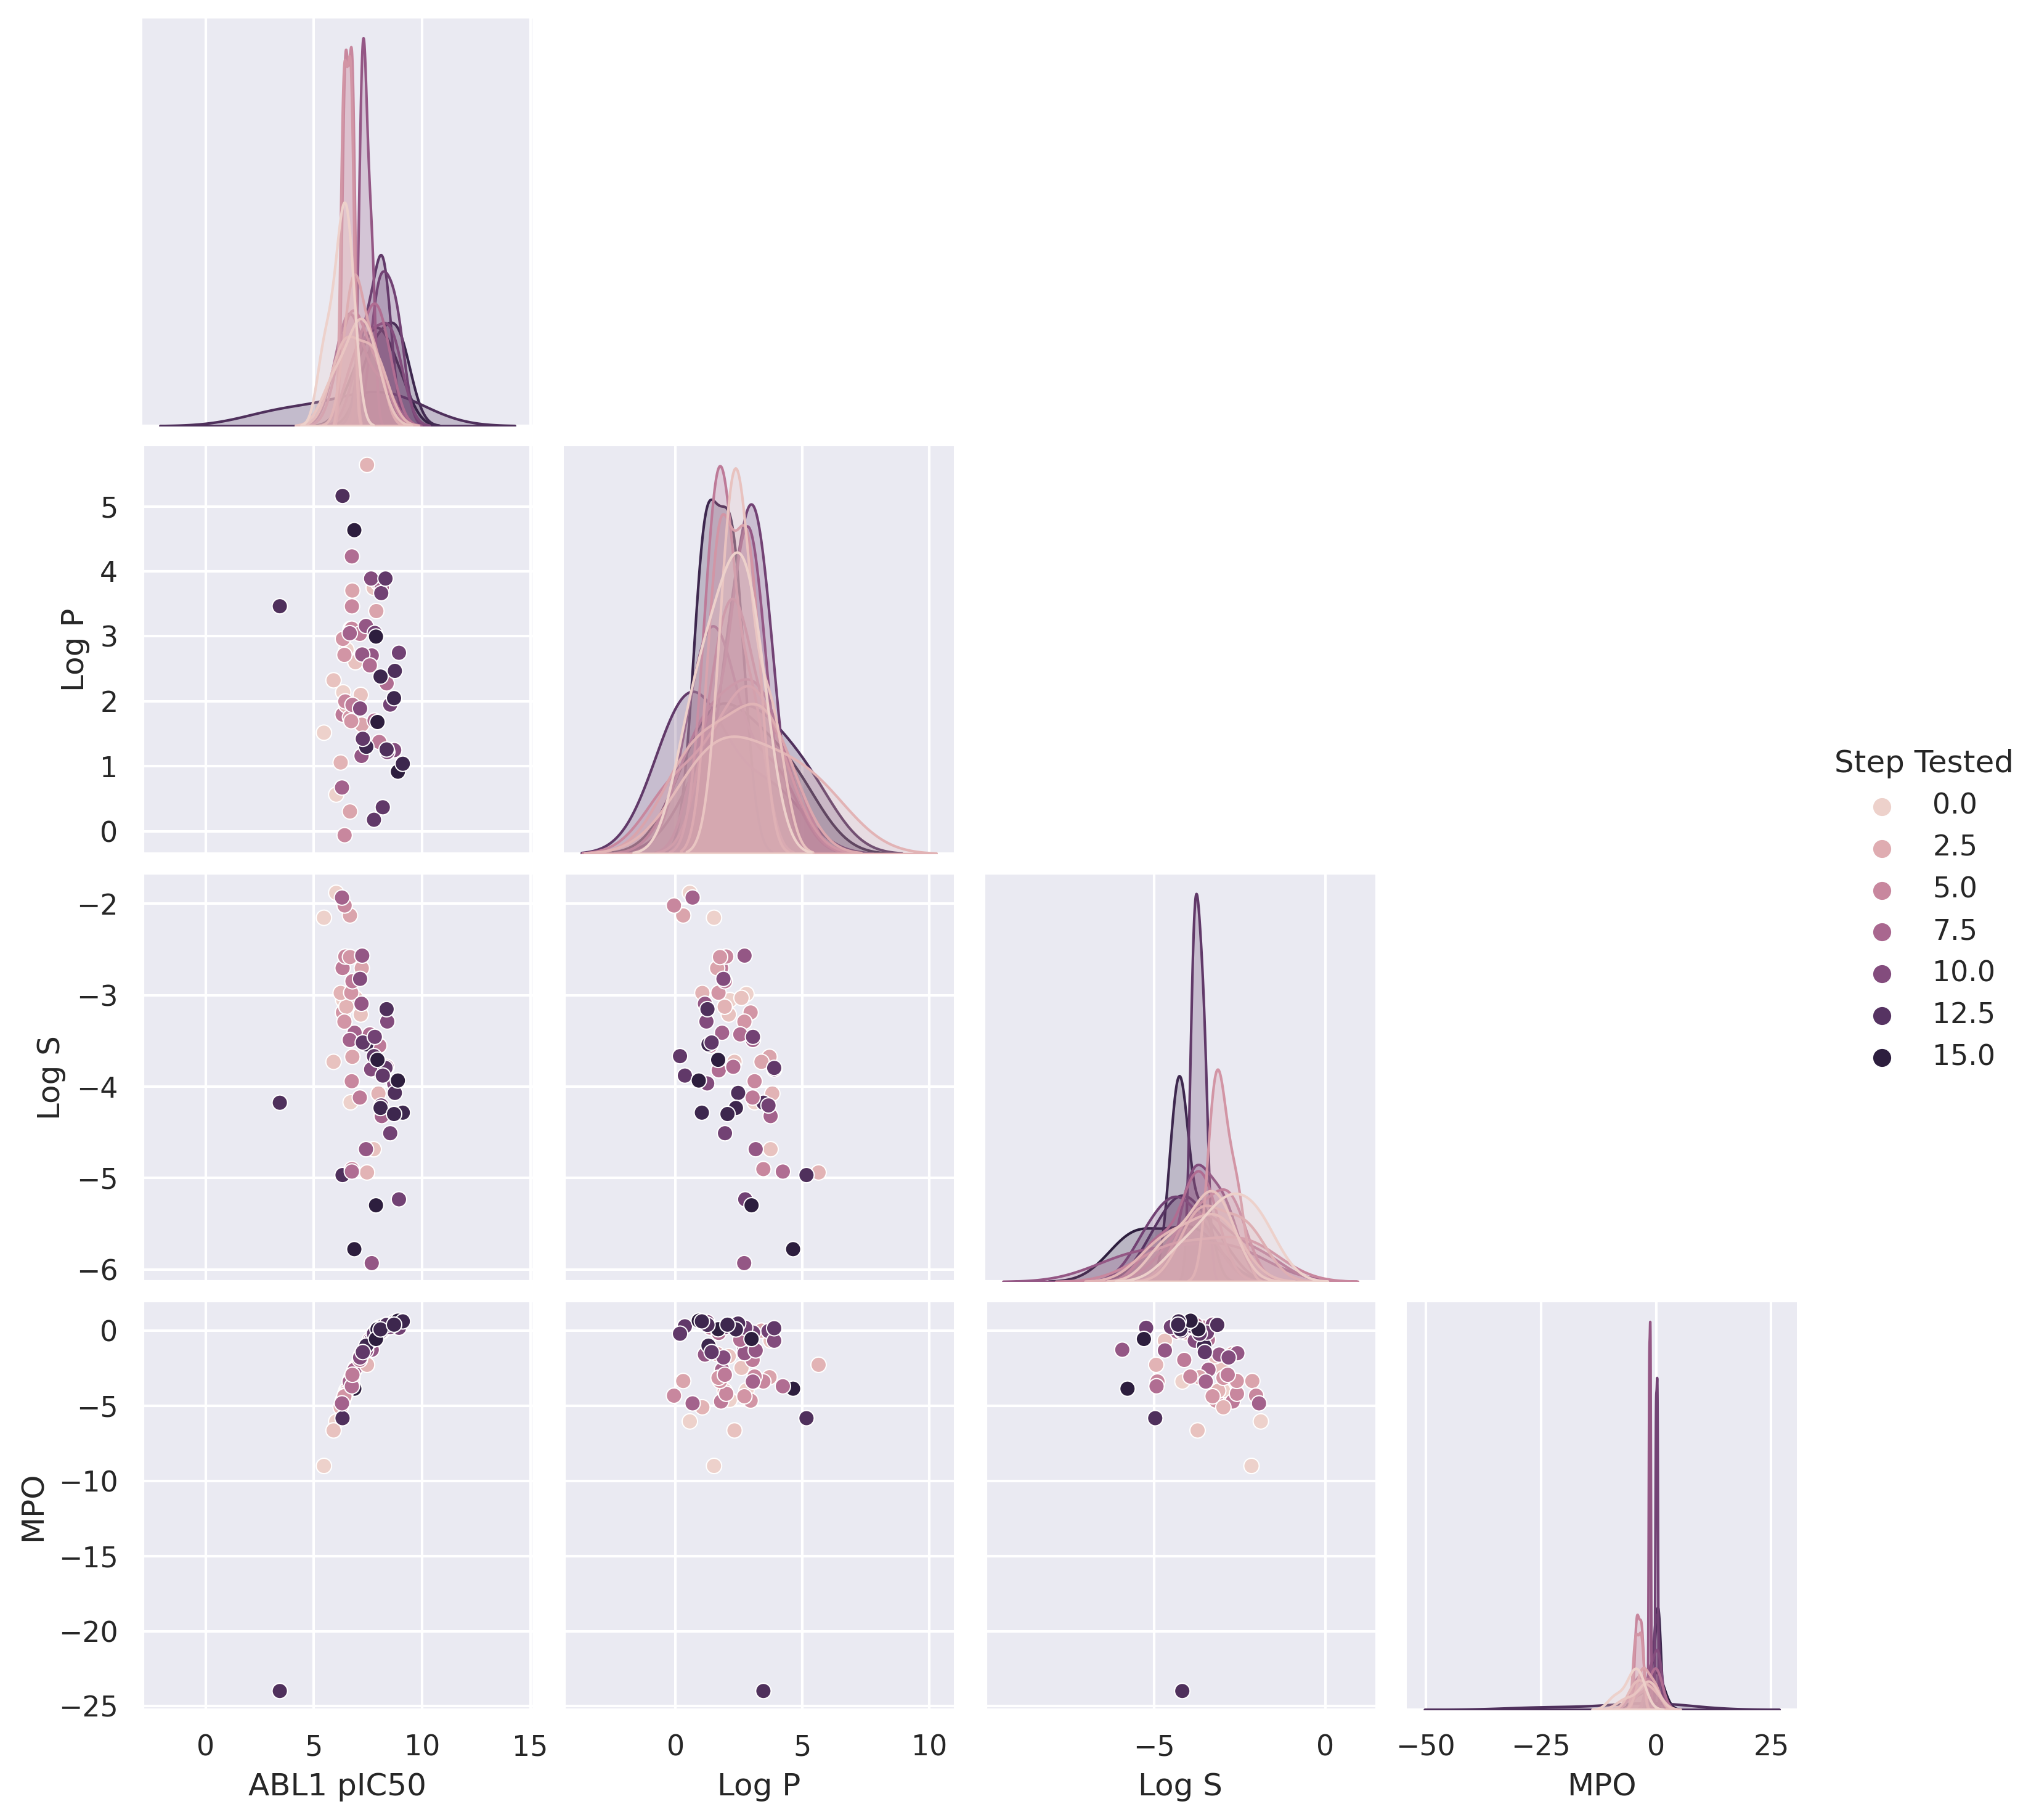

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(dpi=300)

pairplot_df = drug_env.library.annotations[
    ['ABL1 pIC50', 'Log P', 'Log S', 'Step Tested']
]

pairplot_df['MPO'] = drug_env.utility_function(drug_env.library, use_precomputed=True, method='average')

sns.set_theme()
g = sns.pairplot(
    pairplot_df,
    corner=True,
    hue='Step Tested'
)
g.fig.set_dpi(300)

In [17]:
max_timestep = int(drug_env.library.annotations['Step Tested'].max())

objective = 'ABL1 pIC50'
records = []
for timestep, group in pairplot_df.groupby('Step Tested'):
    for _, mol in group.iterrows():
        record = {
            'pIC50': mol[objective], 'Step Tested': timestep}
        records.append(record)
        
        # Duplicate logic for each possible timestep
        for t in range(1, max_timestep + 1):
            if timestep < t:
                records.append({**record, 'Step Tested': t})

df = pd.DataFrame(records)

/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0.5, 1.0, 'Distribution of ligand potencies across rounds')

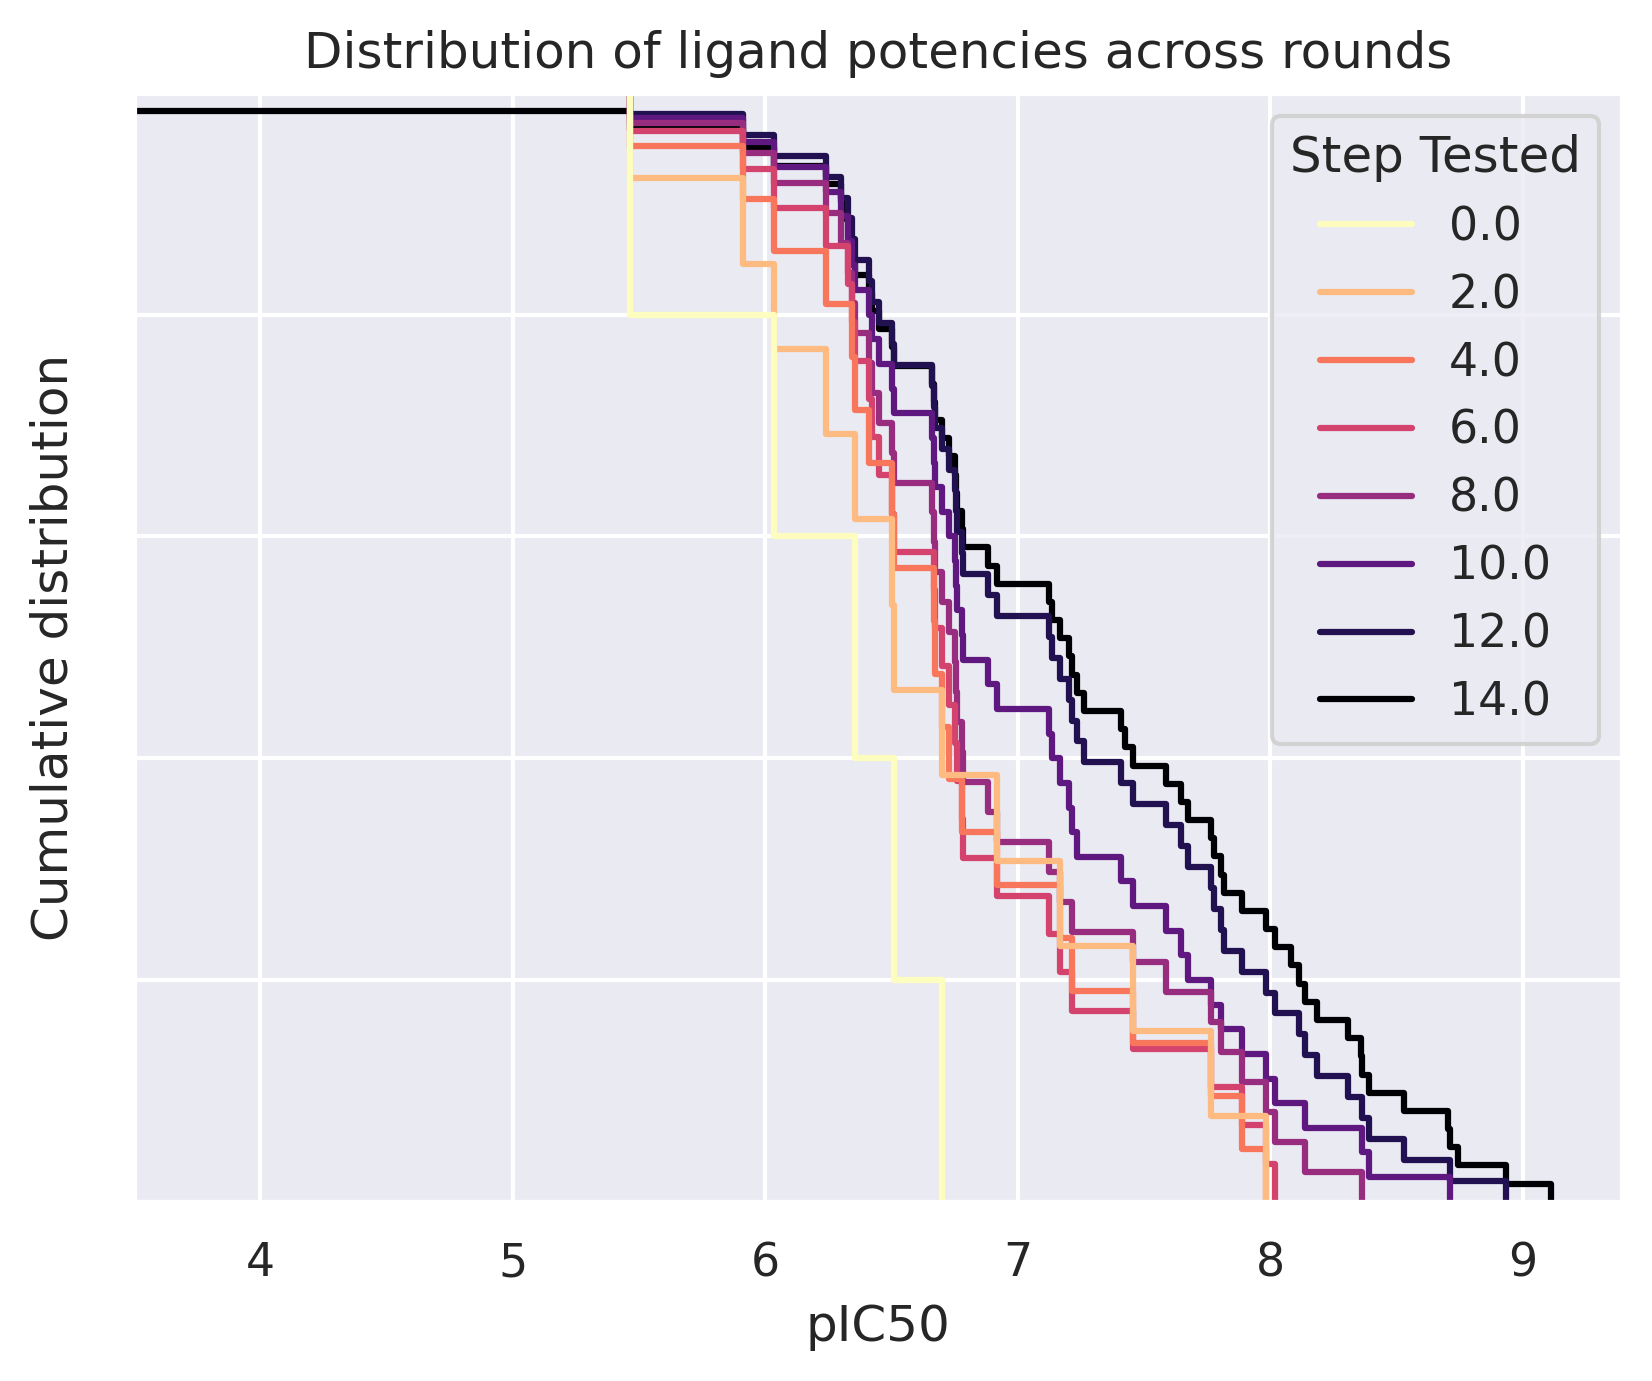

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
plt.figure(dpi=300)

g = sns.ecdfplot(
    df.query('`Step Tested` % 2 == 0'),
    x='pIC50',
    hue='Step Tested',
    palette='magma_r',
    complementary=True
)

g.set(yticklabels=[])

plt.xlim(3.5)
plt.xlabel('pIC50')
plt.ylabel('Cumulative distribution')
plt.title('Distribution of ligand potencies across rounds')